Using challenges file: c:\Users\aibel\OneDrive\Documents\Code\arc-agi\default\arc-agi_training_challenges.json
Displayed 5 original puzzles from default dataset: ['00576224', '007bbfb7', '009d5c81', '00d62c1b', '00dbd492']
Displayed 5 original puzzles from default dataset: ['00576224', '007bbfb7', '009d5c81', '00d62c1b', '00dbd492']


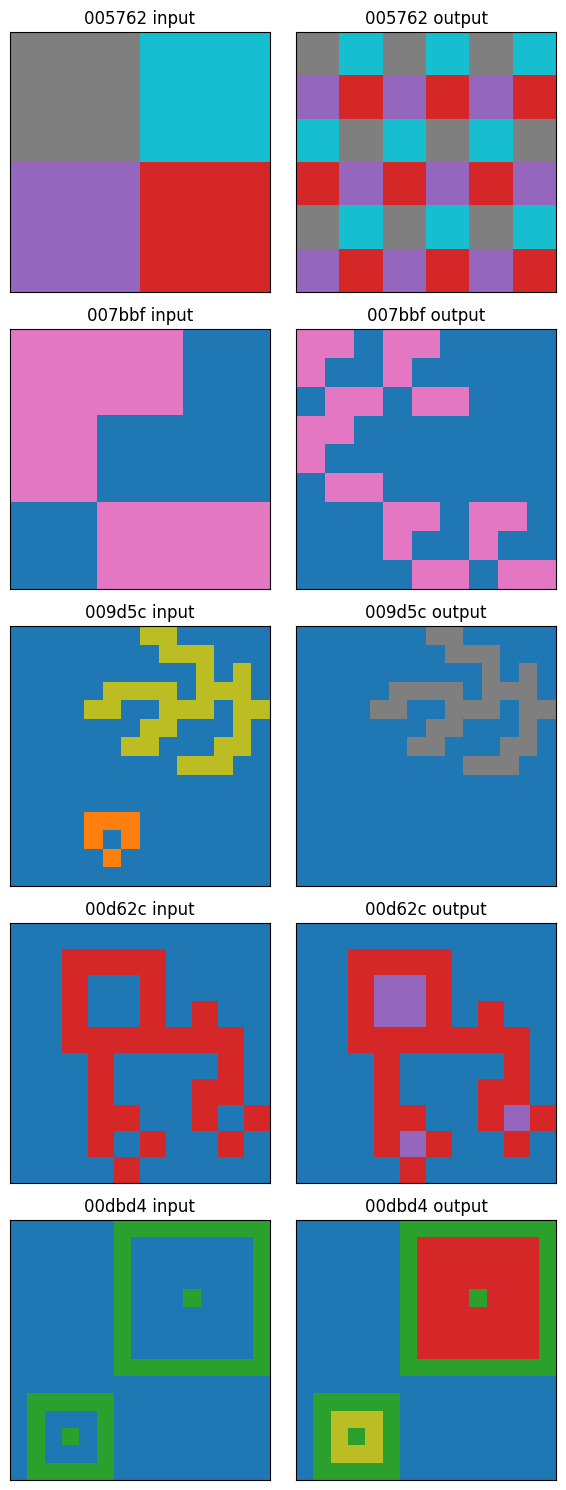

In [10]:
# Cell 1: Display 5 puzzles from the original ARC training dataset in the default folder
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# Robustly locate the project root that contains the 'default' folder
start = Path.cwd()
challenges_rel = Path('default') / 'arc-agi_training_challenges.json'
challenges_path = None
for p in [start, *start.parents]:
    candidate = p / challenges_rel
    if candidate.exists():
        challenges_path = candidate
        break
if challenges_path is None:
    raise FileNotFoundError(f"Could not locate {challenges_rel} starting from {start}")
print('Using challenges file:', challenges_path)

with challenges_path.open('r') as f:
    data = json.load(f)

# Normalize into a list of task dicts with a task_id key
tasks = []
if isinstance(data, dict):
    for k, v in data.items():
        t = dict(v)
        t['task_id'] = k
        tasks.append(t)
elif isinstance(data, list):
    for t in data:
        task_id = t.get('task_id') or t.get('id')
        td = dict(t)
        td['task_id'] = task_id
        tasks.append(td)
else:
    raise ValueError('Unexpected JSON structure for training challenges')

if len(tasks) < 5:
    raise ValueError(f'Not enough tasks found ({len(tasks)}) to display 5')

selected_tasks = tasks[:5]
selected_task_ids = [t['task_id'] for t in selected_tasks]

# Store original first train pair for comparison in Cell 2
orig_first_pairs = {}

def _norm(grid):
    if isinstance(grid, (int, np.integer)):
        return [[int(grid)]]
    if isinstance(grid, list):
        if not grid:
            return []
        if isinstance(grid[0], list):
            return [[int(c) for c in r] for r in grid]
        return [[int(c) for c in grid]]
    arr = np.array(grid)
    if arr.ndim == 0:
        return [[int(arr)]]
    if arr.ndim == 1:
        return [arr.astype(int).tolist()]
    return arr.astype(int).tolist()

rows = len(selected_tasks)
fig, axes = plt.subplots(rows, 2, figsize=(6, 3*rows))
if rows == 1:
    axes = np.array([axes])

cmap = plt.get_cmap('tab10', 10)

for i, task in enumerate(selected_tasks):
    train_list = task.get('train') or []
    if not train_list:
        inp = out = []
    else:
        pair = train_list[0]
        inp = _norm(pair.get('input', []))
        out = _norm(pair.get('output', []))
    orig_first_pairs[task['task_id']] = (inp, out)
    arr_in = np.array(inp, dtype=int) if inp else np.zeros((1,1), dtype=int)
    arr_out = np.array(out, dtype=int) if out else np.zeros((1,1), dtype=int)
    ax_in = axes[i,0]; ax_out = axes[i,1]
    ax_in.imshow(arr_in, cmap=cmap, vmin=0, vmax=9)
    ax_out.imshow(arr_out, cmap=cmap, vmin=0, vmax=9)
    ax_in.set_title(f"{task['task_id'][:6]} input")
    ax_out.set_title(f"{task['task_id'][:6]} output")
    for ax in (ax_in, ax_out):
        ax.set_xticks([]); ax.set_yticks([])

plt.tight_layout()
print('Displayed 5 original puzzles from default dataset:', selected_task_ids)

Using artifacts dataset file: c:\Users\aibel\OneDrive\Documents\Code\arc-agi\artifacts\datasets\training.jsonl


Displayed converted puzzles for task_ids: ['00576224', '007bbfb7', '009d5c81', '00d62c1b', '00dbd492']
All converted entries match original first train pairs.


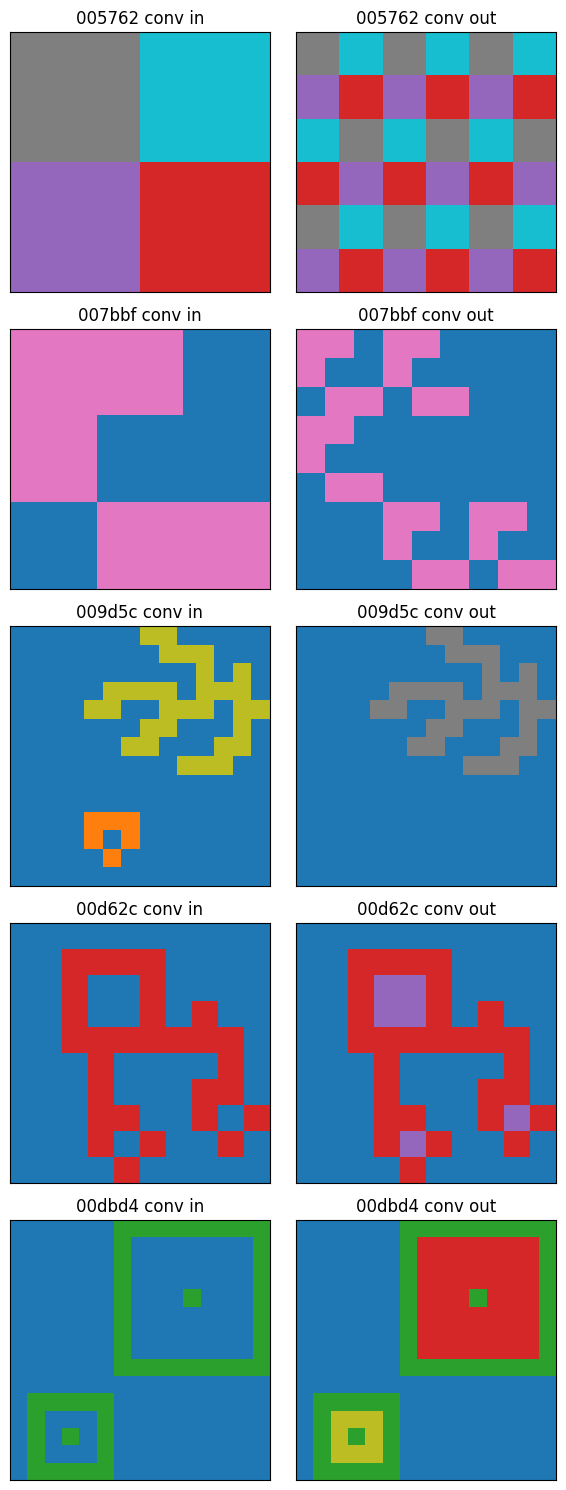

In [11]:
# Cell 2: Display same 5 puzzles from artifacts dataset and report mismatches
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

if 'selected_task_ids' not in globals() or 'orig_first_pairs' not in globals():
    raise RuntimeError('Run Cell 1 first to populate selected_task_ids and orig_first_pairs')

# Locate artifacts dataset
start = Path.cwd()
rel_jsonl = Path('artifacts') / 'datasets' / 'training.jsonl'
jsonl_path = None
for p in [start, *start.parents]:
    candidate = p / rel_jsonl
    if candidate.exists():
        jsonl_path = candidate
        break
if jsonl_path is None:
    raise FileNotFoundError(f'Could not locate {rel_jsonl} starting from {start}')
print('Using artifacts dataset file:', jsonl_path)

wanted = set(selected_task_ids)
records = {}
with jsonl_path.open('r') as f:
    for line in f:
        if len(records) == len(wanted):
            break
        line = line.strip()
        if not line:
            continue
        try:
            rec = json.loads(line)
        except json.JSONDecodeError:
            continue
        tid = rec.get('task_id')
        if tid in wanted and rec.get('subset') == 'train' and rec.get('index') == 0:
            records[tid] = rec

missing = [tid for tid in selected_task_ids if tid not in records]
if missing:
    print('Warning: missing converted entries for task_ids:', missing)

rows = len(selected_task_ids)
fig2, axes2 = plt.subplots(rows, 2, figsize=(6, 3*rows))
if rows == 1:
    axes2 = np.array([axes2])

cmap = plt.get_cmap('tab10', 10)

def _norm(grid):
    if isinstance(grid, (int, np.integer)):
        return [[int(grid)]]
    if isinstance(grid, list):
        if not grid:
            return []
        if isinstance(grid[0], list):
            return [[int(c) for c in r] for r in grid]
        return [[int(c) for c in grid]]
    arr = np.array(grid)
    if arr.ndim == 0:
        return [[int(arr)]]
    if arr.ndim == 1:
        return [arr.astype(int).tolist()]
    return arr.astype(int).tolist()

mismatches = []
for i, tid in enumerate(selected_task_ids):
    rec = records.get(tid)
    if rec is None:
        inp = out = []
    else:
        inp = _norm(rec.get('input', []))
        out = _norm(rec.get('output', []))
    orig_in, orig_out = orig_first_pairs[tid]
    same_in = (inp == orig_in)
    same_out = (out == orig_out)
    if rec is not None and (not same_in or not same_out):
        mismatches.append({'task_id': tid, 'input_equal': same_in, 'output_equal': same_out,
                           'orig_in_shape': (len(orig_in), len(orig_in[0]) if orig_in else 0),
                           'conv_in_shape': (len(inp), len(inp[0]) if inp else 0),
                           'orig_out_shape': (len(orig_out), len(orig_out[0]) if orig_out else 0),
                           'conv_out_shape': (len(out), len(out[0]) if out else 0)})
    arr_in = np.array(inp, dtype=int) if inp else np.zeros((1,1), dtype=int)
    arr_out = np.array(out, dtype=int) if out else np.zeros((1,1), dtype=int)
    ax_in = axes2[i,0]; ax_out = axes2[i,1]
    ax_in.imshow(arr_in, cmap=cmap, vmin=0, vmax=9)
    ax_out.imshow(arr_out, cmap=cmap, vmin=0, vmax=9)
    ax_in.set_title(f"{tid[:6]} conv in{' *' if not same_in else ''}")
    ax_out.set_title(f"{tid[:6]} conv out{' *' if not same_out else ''}")
    for ax in (ax_in, ax_out):
        ax.set_xticks([]); ax.set_yticks([])

plt.tight_layout()
print('Displayed converted puzzles for task_ids:', selected_task_ids)
if mismatches:
    print('MISMATCH SUMMARY:')
    for m in mismatches:
        print(m)
else:
    print('All converted entries match original first train pairs.')